## GOING BEYOND THE SEQUENTIAL MODEL: THE KERAS FUNCTIONAL API

In the functional API, you directly manipulate tensors, and you use layers as functions that take tensors and return tensors

### Introduction to the functional API

In [1]:
from keras import Input, layers

input_tensor = Input(shape=(32,))                   
dense = layers.Dense(32, activation='relu')         

output_tensor = dense(input_tensor)                 

/Users/hakan/.pyenv/versions/3.6.4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense

seq_model = Sequential()                                               
seq_model.add(Dense(32, activation='relu', input_shape=(64,)))
seq_model.add(Dense(32, activation='relu'))
seq_model.add(Dense(10, activation='softmax'))


input_tensor = Input(shape=(64,))                                      
x = Dense(32, activation='relu')(input_tensor)                  
x = Dense(32, activation='relu')(x)                             
output_tensor = Dense(10, activation='softmax')(x)              

model = Model(input_tensor, output_tensor)                             

model.summary()                                                        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


In [ ]:
unrelated_input = Input(shape=(32,))
bad_model = model = Model(unrelated_input, output_tensor)

In [5]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

import numpy as np                                                 
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10))

model.fit(x_train, y_train, epochs=10, batch_size=128)                   

score = model.evaluate(x_train, y_train)         

Epoch 1/10
1000/1000 [==============================] - 0s 304us/step - loss: 11.6280
Epoch 2/10
1000/1000 [==============================] - 0s 29us/step - loss: 11.5843
Epoch 3/10
1000/1000 [==============================] - 0s 30us/step - loss: 11.5756
Epoch 4/10
1000/1000 [==============================] - 0s 40us/step - loss: 11.5705
Epoch 5/10
1000/1000 [==============================] - 0s 37us/step - loss: 11.5665
Epoch 6/10
1000/1000 [==============================] - 0s 37us/step - loss: 11.5640
Epoch 7/10
1000/1000 [==============================] - 0s 27us/step - loss: 11.5620
Epoch 8/10
1000/1000 [==============================] - 0s 30us/step - loss: 11.5602
Epoch 9/10
1000/1000 [==============================] - 0s 38us/step - loss: 11.5584
Epoch 10/10
1000/1000 [==============================] - 0s 89us/step


### Multi-input models

In [9]:
text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500


text_input = Input(shape=(None,), dtype='int32', name='text')            
embedded_text = layers.Embedding(64, text_vocabulary_size)(text_input)                                
encoded_text = layers.LSTM(32)(embedded_text)                            

question_input = Input(shape=(None,),dtype='int32', name='question')                                  
embedded_question = layers.Embedding(32, question_vocabulary_size)(question_input)
encoded_question = layers.LSTM(16)(embedded_question)


concatenated = layers.concatenate([encoded_text, encoded_question], axis=-1)                               

answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated)                

model = Model([text_input, question_input], answer)                      
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
question (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 10000)  640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 10000)  320000      question[0][0]                   
__________________________________________________________________________________________________
lstm_3 (LS

In [ ]:
import numpy as np

num_samples = 1000
max_length = 100

text = np.random.randint(1, text_vocabulary_size, size=(num_samples, max_length))                   
question = np.random.randint(1, question_vocabulary_size, size=(num_samples, max_length))
answers = np.random.randint(0, 1,size=(num_samples, answer_vocabulary_size))    

model.fit([text, question], answers, epochs=10, batch_size=128)            
# or
model.fit({'text': text, 'question': question}, answers,epochs=10, batch_size=128)                                       

### Multi-output models

In [10]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding
from keras import Input
from keras.models import Model

vocabulary_size = 50000
num_income_groups = 10

posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = Embedding(256, vocabulary_size)(posts_input)

x = Conv1D(128, 5, activation='relu')(embedded_posts)
x = MaxPooling1D(5)(x)
x = Conv1D(256, 5, activation='relu')(x)
x = Conv1D(256, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(256, 5, activation='relu')(x)
x = Conv1D(256, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)


age_prediction = Dense(1, name='age')(x)               
income_prediction = Dense(num_income_groups,
                                 activation='softmax',
                                 name='income')(x)
gender_prediction = Dense(1, activation='sigmoid', name='gender')(x)

model = Model(posts_input,
              [age_prediction, income_prediction, gender_prediction])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [ ]:
model.compile(optimizer='rmsprop',
              loss=[ 'mse', 'categorical_crossentropy', 'binary_crossentropy'])

# or 

model.compile(optimizer='rmsprop',                             
              loss={'age': 'mse',                              
                    'income': 'categorical_crossentropy',      
                    'gender': 'binary_crossentropy'})          

Note that very imbalanced loss contributions will cause the model representations to be optimized preferentially for the task with the largest individual loss, at the expense of the other tasks.  You can assign different levels of importance to the loss values in their contribution to the final loss.

In [ ]:
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
              loss_weights=[0.25, 1., 10.])

# or

model.compile(optimizer='rmsprop',                            
              loss={'age': 'mse',                             
                    'income': 'categorical_crossentropy',     
                    'gender': 'binary_crossentropy'},         
              loss_weights={'age': 0.25,                      
                            'income': 1.,                     
                            'gender': 10.})                   

In [ ]:
model.fit(posts, [age_targets, income_targets, gender_targets],        
          epochs=10, batch_size=64)

model.fit(posts, {'age': age_targets,                                  
                  'income': income_targets,                            
                  'gender': gender_targets},                           
          epochs=10, batch_size=64)               

### Layer weight sharing

In [ ]:
from keras.layers import LSTM, Dense 
from keras import Input
from keras.models import Model
import keras.layers.concatenate as con

lstm = LSTM(32)                                                
left_input = Input(shape=(None, 128))                                 
left_output = lstm(left_input)                                        

right_input = Input(shape=(None, 128))                                
right_output = lstm(right_input)                                      

merged = con([left_output, right_output], axis=-1)     
predictions = layers.Dense(1, activation='sigmoid')(merged)           

model = Model([left_input, right_input], predictions)  

model.fit([left_data, right_data], targets...)                           

### Models as layers

In [ ]:
y = model(x)

In [ ]:
y1, y2 = model([x1, x2])

In [ ]:
from keras import layers
from keras import applications
from keras import Input

xception_base = applications.Xception(weights=None,include_top=False)      

left_input = Input(shape=(250, 250, 3))                       
right_input = Input(shape=(250, 250, 3))                      

left_features = xception_base(left_input)                     
right_input = xception_base(right_input)                      

merged_features = layers.concatenate([left_features, right_input], axis=-1)             

## INSPECTING AND MONITORING DEEP-LEARNING MODELS USING KERAS CALLBAACKS AND TENSORBOARD

The keras.callbacks module includes a number of built-in callbacks (this is not an exhaustive list):
    
* `keras.callbacks.ModelCheckpoint`
* `keras.callbacks.EarlyStopping`
* `keras.callbacks.LearningRateScheduler`
* `keras.callbacks.ReduceLROnPlateau`
* `keras.callbacks.CSVLogger`

In [ ]:
import keras

callbacks_list = [                              
    keras.callbacks.EarlyStopping(              
        monitor='acc',                          
        patience=1,                             
    ),
    keras.callbacks.ModelCheckpoint(            
        filepath='my_model.h5',                 
        monitor='val_loss',                     
        save_best_only=True,                    
    )
]

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])                  

model.fit(x, y,             
          epochs=10,
          batch_size=32,
          callbacks=callbacks_list, #!
          validation_data=(x_val, y_val)) # Note that because the callback will monitor validation loss and validation accuracy, you need to pass validation_data to the call to fit.

you can write your own callback. Callbacks are implemented by subclassing the class `keras.callbacks.Callback`. You can then implement any number of the following transparently named methods:

* `on_epoch_begin`    1      
* `on_epoch_end`      2    

* `on_batch_begin`   3     
* `on_batch_end`      4     

* `on_train_begin`    5     
* `on_train_end`      6 


1 Called at the start of every epoch

2 Called at the end of every epoch

3 Called right before processing each batch

4 Called right after processing each batch

5 Called at the start of training

6 Called at the end of training

In [14]:
import keras

class ActivationLogger(keras.callbacks.Callback):

    def set_model(self, model):
        self.model = model                                               
        layer_outputs = [layer.output for layer in model.layers]
        self.activations_model = keras.models.Model(model.input,layer_outputs)       

    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')

        validation_sample = self.validation_data[0][0:1]                 
        activations = self.activations_model.predict(validation_sample)
        f = open('activations_at_epoch_' + str(epoch) + '.npz', 'w')     
        np.savez(f, activations)                                         
        f.close()  

### Introduction to TensorBoard: the TensorFlow visualization framework

In [2]:
import keras
from keras import layers
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 2000                                              
max_len = 500                                                    

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

/Users/hakan/.pyenv/versions/3.6.4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
model = keras.models.Sequential()
model.add(layers.Embedding(max_features, 128,input_length=max_len,name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainab

In [16]:
!mkdir my_log_dir

In [17]:
callbacks = [
    keras.callbacks.TensorBoard(
        log_dir='my_log_dir',                  
        histogram_freq=1,                      
        embeddings_freq=1,                     
    )
]

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 67s 3ms/step - loss: 0.6326 - acc: 0.6522 - val_loss: 0.4155 - val_acc: 0.8302
Epoch 2/20
20000/20000 [==============================] - 63s 3ms/step - loss: 0.4367 - acc: 0.8149 - val_loss: 0.7051 - val_acc: 0.7046
Epoch 3/20
20000/20000 [==============================] - 77s 4ms/step - loss: 0.4001 - acc: 0.7883 - val_loss: 1.4597 - val_acc: 0.4790
Epoch 4/20
20000/20000 [==============================] - 89s 4ms/step - loss: 0.3467 - acc: 0.7799 - val_loss: 0.4892 - val_acc: 0.7716
Epoch 5/20
20000/20000 [==============================] - 71s 4ms/step - loss: 0.3129 - acc: 0.7148 - val_loss: 0.5548 - val_acc: 0.7030
Epoch 6/20
20000/20000 [==============================] - 79s 4ms/step - loss: 0.2696 - acc: 0.6955 - val_loss: 0.5955 - val_acc: 0.6504
Epoch 7/20
20000/20000 [==============================] - 65s 3ms/step - loss: 0.2280 - acc: 0.6541 - val_loss: 0.6513 - val_acc:

In [19]:
model.save("trained_visual_model.h5")

In [4]:
model.load_weights('trained_visual_model.h5')

Lunch `tensorboard --logdir=my_log_dir` from the command line. You can then browse to http://localhost:6006 and look at your model training

In [5]:
from keras.utils import plot_model

plot_model(model, to_file='model.png')

In [6]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, to_file='model_shape.png')

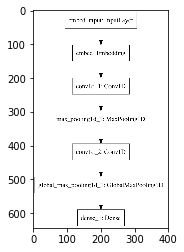

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

img=mpimg.imread('model.png')
plt.imshow(img)
plt.show()